# Random Forest Classification - Breast Cancer Wisconsin Dataset

## Project Overview
This notebook implements a Random Forest classifier for the Breast Cancer Wisconsin (Diagnostic) dataset. We will cover the complete machine learning pipeline including data preprocessing, model training, hyperparameter tuning, and performance optimization using feature selection and SMOTE for handling class imbalance.

## 1. Environment Setup and Library Imports

In [10]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset
from ucimlrepo import fetch_ucirepo

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Model
from sklearn.ensemble import RandomForestClassifier

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)

# Visualization
from sklearn.tree import plot_tree

# Performance improvements
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 2. Data Loading and Exploration

### 2.1 Fetching the Dataset

We use the UCI ML Repository to fetch the Breast Cancer Wisconsin (Diagnostic) dataset.


In [11]:
# Fetch the Breast Cancer Wisconsin (Diagnostic) dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# Extract features and target
X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

# Display metadata
print("="*60)
print("DATASET METADATA")
print("="*60)
print(breast_cancer_wisconsin_diagnostic.metadata)

DATASET METADATA
{'uci_id': 17, 'name': 'Breast Cancer Wisconsin (Diagnostic)', 'repository_url': 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic', 'data_url': 'https://archive.ics.uci.edu/static/public/17/data.csv', 'abstract': 'Diagnostic Wisconsin Breast Cancer Database.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 569, 'num_features': 30, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Diagnosis'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5DW2B', 'creators': ['William Wolberg', 'Olvi Mangasarian', 'Nick Street', 'W. Street'], 'intro_paper': {'ID': 230, 'type': 'NATIVE', 'title': 'Nuclear feature extraction for breast tumor diagnosis', 'authors': 'W. Street, W. Wolberg, O. Mangasarian', 'venue': 'Electronic imaging', 'year': 1993, 'journal'

### 2.2 Variable Information

In [12]:
# Display variable information
print("="*60)
print("VARIABLE INFORMATION")
print("="*60)
print(breast_cancer_wisconsin_diagnostic.variables)

VARIABLE INFORMATION
                  name     role         type demographic description units  \
0                   ID       ID  Categorical        None        None  None   
1            Diagnosis   Target  Categorical        None        None  None   
2              radius1  Feature   Continuous        None        None  None   
3             texture1  Feature   Continuous        None        None  None   
4           perimeter1  Feature   Continuous        None        None  None   
5                area1  Feature   Continuous        None        None  None   
6          smoothness1  Feature   Continuous        None        None  None   
7         compactness1  Feature   Continuous        None        None  None   
8           concavity1  Feature   Continuous        None        None  None   
9      concave_points1  Feature   Continuous        None        None  None   
10           symmetry1  Feature   Continuous        None        None  None   
11  fractal_dimension1  Feature   Continuou

### 2.3 Data Overview

In [13]:
# Display basic information about the dataset
print("="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"\nFeature names:\n{list(X.columns)}")

# Display first few rows
print("\n" + "="*60)
print("FIRST 5 ROWS OF FEATURES")
print("="*60)
X.head()

DATASET OVERVIEW
Number of samples: 569
Number of features: 30

Feature names:
['radius1', 'texture1', 'perimeter1', 'area1', 'smoothness1', 'compactness1', 'concavity1', 'concave_points1', 'symmetry1', 'fractal_dimension1', 'radius2', 'texture2', 'perimeter2', 'area2', 'smoothness2', 'compactness2', 'concavity2', 'concave_points2', 'symmetry2', 'fractal_dimension2', 'radius3', 'texture3', 'perimeter3', 'area3', 'smoothness3', 'compactness3', 'concavity3', 'concave_points3', 'symmetry3', 'fractal_dimension3']

FIRST 5 ROWS OF FEATURES


,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### 2.4 Target Distribution

TARGET DISTRIBUTION
Diagnosis
B            357
M            212
Name: count, dtype: int64


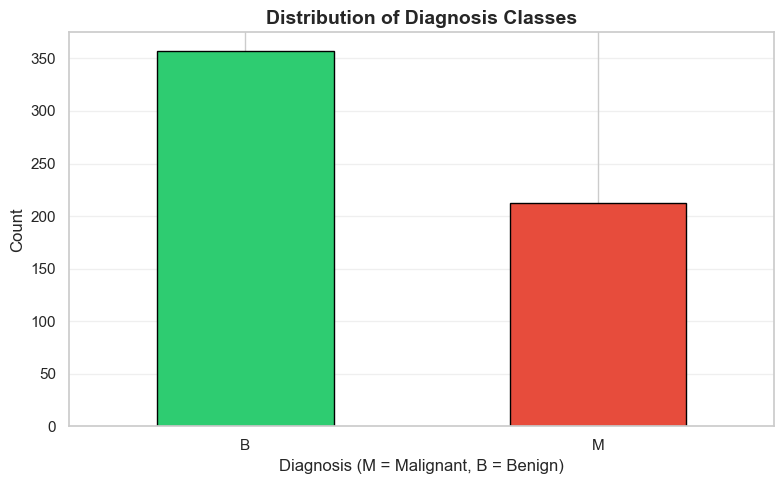


Class distribution percentage:
Diagnosis
B    62.741652
M    37.258348
Name: proportion, dtype: float64


In [14]:
# Examine target variable
print("="*60)
print("TARGET DISTRIBUTION")
print("="*60)
print(y.value_counts())

# Visualize target distribution
plt.figure(figsize=(8, 5))
y['Diagnosis'].value_counts().plot(kind='bar', color=['#2ecc71', '#e74c3c'], edgecolor='black')
plt.title('Distribution of Diagnosis Classes', fontsize=14, fontweight='bold')
plt.xlabel('Diagnosis (M = Malignant, B = Benign)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate class imbalance ratio
print(f"\nClass distribution percentage:")
print(y['Diagnosis'].value_counts(normalize=True) * 100)

### 2.5 Statistical Summary

In [15]:
# Display statistical summary of features
print("="*60)
print("STATISTICAL SUMMARY")
print("="*60)
X.describe()

STATISTICAL SUMMARY


,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


## 3. Data Preprocessing


### 3.1 Missing Values Check


In [16]:
# Check for missing values
print("="*60)
print("MISSING VALUES CHECK")
print("="*60)
missing_values = X.isnull().sum()
print(f"Total missing values per feature:\n{missing_values}")
print(f"\nTotal missing values in dataset: {missing_values.sum()}")

# If there are missing values, handle them
if missing_values.sum() > 0:
    # Strategy: Fill with median (robust to outliers)
    X = X.fillna(X.median())
    print("\nMissing values have been filled with median values.")
else:
    print("\nNo missing values found. Data is complete.")

MISSING VALUES CHECK
Total missing values per feature:
radius1               0
texture1              0
perimeter1            0
area1                 0
smoothness1           0
compactness1          0
concavity1            0
concave_points1       0
symmetry1             0
fractal_dimension1    0
radius2               0
texture2              0
perimeter2            0
area2                 0
smoothness2           0
compactness2          0
concavity2            0
concave_points2       0
symmetry2             0
fractal_dimension2    0
radius3               0
texture3              0
perimeter3            0
area3                 0
smoothness3           0
compactness3          0
concavity3            0
concave_points3       0
symmetry3             0
fractal_dimension3    0
dtype: int64

Total missing values in dataset: 0

No missing values found. Data is complete.


### 3.2 Target Encoding


In [17]:
# Encode target variable (M = Malignant = 1, B = Benign = 0)
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y['Diagnosis'])

print("="*60)
print("TARGET ENCODING")
print("="*60)
print(f"Original classes: {le.classes_}")
print(f"Encoded mapping: B -> 0, M -> 1")
print(f"\nEncoded target distribution:")
unique, counts = np.unique(y_encoded, return_counts=True)
for val, count in zip(unique, counts):
    print(f"  Class {val}: {count} samples")

TARGET ENCODING
Original classes: ['B' 'M']
Encoded mapping: B -> 0, M -> 1

Encoded target distribution:
  Class 0: 357 samples
  Class 1: 212 samples


### 3.3 Feature Scaling


In [18]:
# Apply StandardScaler for feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame for better readability
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print("="*60)
print("FEATURE SCALING (StandardScaler)")
print("="*60)
print("Features have been standardized (mean=0, std=1)")
print(f"\nScaled features statistics:")
print(f"Mean of scaled features: {X_scaled.mean(axis=0).round(2)[:5]}... (first 5 shown)")
print(f"Std of scaled features: {X_scaled.std(axis=0).round(2)[:5]}... (first 5 shown)")

FEATURE SCALING (StandardScaler)
Features have been standardized (mean=0, std=1)

Scaled features statistics:
Mean of scaled features: [-0.  0. -0. -0. -0.]... (first 5 shown)
Std of scaled features: [1. 1. 1. 1. 1.]... (first 5 shown)


### 3.4 Train-Test Split


In [19]:
# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, 
    test_size=0.2, 
    random_state=RANDOM_STATE,
    stratify=y_encoded  # Maintain class distribution
)

print("="*60)
print("TRAIN-TEST SPLIT (80/20)")
print("="*60)
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"\nTraining set class distribution:")
unique, counts = np.unique(y_train, return_counts=True)
for val, count in zip(unique, counts):
    print(f"  Class {val}: {count} samples ({100*count/len(y_train):.1f}%)")

TRAIN-TEST SPLIT (80/20)
Training set size: 455 samples
Testing set size: 114 samples

Training set class distribution:
  Class 0: 285 samples (62.6%)
  Class 1: 170 samples (37.4%)


## 4. Baseline Random Forest Model


### 4.1 Training the Baseline Model


In [20]:
# Initialize baseline Random Forest classifier with default parameters
rf_baseline = RandomForestClassifier(random_state=RANDOM_STATE)

# Train the model
rf_baseline.fit(X_train, y_train)

# Make predictions
y_pred_baseline = rf_baseline.predict(X_test)
y_pred_proba_baseline = rf_baseline.predict_proba(X_test)[:, 1]

print("="*60)
print("BASELINE RANDOM FOREST MODEL")
print("="*60)
print("Model trained with default hyperparameters:")
print(f"  n_estimators: {rf_baseline.n_estimators}")
print(f"  max_depth: {rf_baseline.max_depth}")
print(f"  min_samples_split: {rf_baseline.min_samples_split}")
print(f"  min_samples_leaf: {rf_baseline.min_samples_leaf}")
print(f"  max_features: {rf_baseline.max_features}")

BASELINE RANDOM FOREST MODEL
Model trained with default hyperparameters:
  n_estimators: 100
  max_depth: None
  min_samples_split: 2
  min_samples_leaf: 1
  max_features: sqrt


### 4.2 Baseline Model Evaluation

In [21]:
# Calculate evaluation metrics for baseline model
def evaluate_model(y_true, y_pred, y_pred_proba, model_name="Model"):
    """
    Comprehensive model evaluation function.
    
    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred : array-like
        Predicted labels
    y_pred_proba : array-like
        Prediction probabilities for positive class
    model_name : str
        Name of the model for display
    """
    print(f"\n{'='*60}")
    print(f"{model_name.upper()} - EVALUATION METRICS")
    print(f"{'='*60}")
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc
    }

# Evaluate baseline model
baseline_metrics = evaluate_model(
    y_test, y_pred_baseline, y_pred_proba_baseline, 
    "Baseline Random Forest"
)


BASELINE RANDOM FOREST - EVALUATION METRICS
Accuracy:  0.9737
Precision: 1.0000
Recall:    0.9286
F1-Score:  0.9630
ROC-AUC:   0.9929


### 4.3 Baseline Confusion Matrix

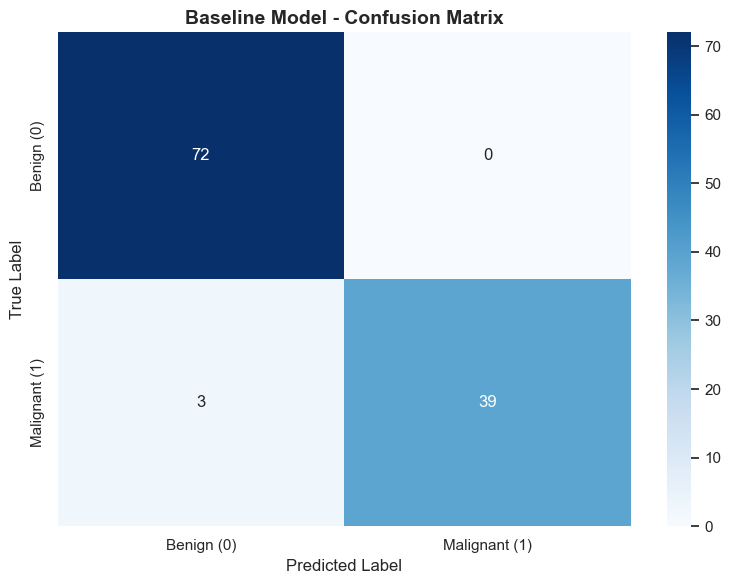

In [22]:
# Plot confusion matrix for baseline model
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    """
    Visualize confusion matrix with annotations.
    """
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Benign (0)', 'Malignant (1)'],
                yticklabels=['Benign (0)', 'Malignant (1)'])
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_test, y_pred_baseline, "Baseline Model - Confusion Matrix")

### 4.4 Classification Report

In [49]:
# Detailed classification report
print("="*60)
print("BASELINE MODEL - CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test, y_pred_baseline, 
                           target_names=['Benign', 'Malignant']))

BASELINE MODEL - CLASSIFICATION REPORT
              precision    recall  f1-score   support

      Benign       0.96      1.00      0.98        72
   Malignant       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



### 4.5 Cross-Validation Score

In [50]:
# Perform 5-fold cross-validation on baseline model
cv_scores_baseline = cross_val_score(rf_baseline, X_scaled, y_encoded, cv=5, scoring='accuracy')

print("="*60)
print("BASELINE MODEL - 5-FOLD CROSS-VALIDATION")
print("="*60)
print(f"CV Scores: {cv_scores_baseline.round(4)}")
print(f"Mean CV Score: {cv_scores_baseline.mean():.4f} (+/- {cv_scores_baseline.std()*2:.4f})")

BASELINE MODEL - 5-FOLD CROSS-VALIDATION
CV Scores: [0.9211 0.9386 0.9825 0.9649 0.9646]
Mean CV Score: 0.9543 (+/- 0.0435)


## 5. Hyperparameter Tuning with GridSearchCV

### 5.1 Define Parameter Grid

In [27]:
# Define hyperparameter grid for tuning
param_grid = {
    'n_estimators': [100, 300, 500, 700, 1000],
    'max_depth': [5, 10, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 10],
    'max_features': ['sqrt', 'log2']
}

print("="*60)
print("HYPERPARAMETER GRID FOR TUNING")
print("="*60)
for param, values in param_grid.items():
    print(f"{param}: {values}")
    
print(f"\nTotal combinations to evaluate: {np.prod([len(v) for v in param_grid.values()])}")

HYPERPARAMETER GRID FOR TUNING
n_estimators: [100, 300, 500, 700, 1000]
max_depth: [5, 10, 15, 20, 25, 30]
min_samples_split: [2, 5, 10, 15, 20]
min_samples_leaf: [1, 2, 4, 6, 10]
max_features: ['sqrt', 'log2']

Total combinations to evaluate: 1500


### 5.2 Optimized Grid Search (Reduced Search Space)

In [52]:
# Reduced parameter grid for faster execution
# (For full search, use the complete param_grid above)
param_grid_reduced = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4],
    'max_features': ['sqrt', 'log2']
}

print("="*60)
print("RUNNING GRID SEARCH CV (Reduced Grid)")
print("="*60)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=RANDOM_STATE),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,  # Use all available cores
    verbose=1
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

print("\n" + "="*60)
print("GRID SEARCH COMPLETED")
print("="*60)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

RUNNING GRID SEARCH CV (Reduced Grid)
Fitting 5 folds for each of 1500 candidates, totalling 7500 fits

GRID SEARCH COMPLETED
Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score: 0.9626


### 5.3 Tuned Model Evaluation


TUNED RANDOM FOREST - EVALUATION METRICS
Accuracy:  0.9737
Precision: 1.0000
Recall:    0.9286
F1-Score:  0.9630
ROC-AUC:   0.9929


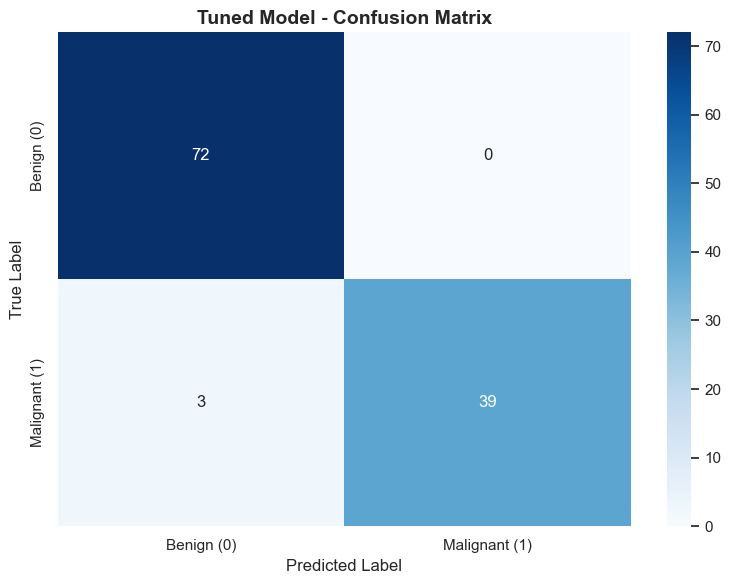

In [53]:
# Get the best model from grid search
rf_tuned = grid_search.best_estimator_

# Make predictions with tuned model
y_pred_tuned = rf_tuned.predict(X_test)
y_pred_proba_tuned = rf_tuned.predict_proba(X_test)[:, 1]

# Evaluate tuned model
tuned_metrics = evaluate_model(
    y_test, y_pred_tuned, y_pred_proba_tuned,
    "Tuned Random Forest"
)

# Plot confusion matrix for tuned model
plot_confusion_matrix(y_test, y_pred_tuned, "Tuned Model - Confusion Matrix")

### 5.4 Performance Comparison: Baseline vs Tuned

PERFORMANCE COMPARISON: BASELINE vs TUNED
   Metric  Baseline    Tuned  Improvement
 Accuracy  0.973684 0.973684          0.0
Precision  1.000000 1.000000          0.0
   Recall  0.928571 0.928571          0.0
 F1-Score  0.962963 0.962963          0.0
  ROC-AUC  0.992890 0.992890          0.0


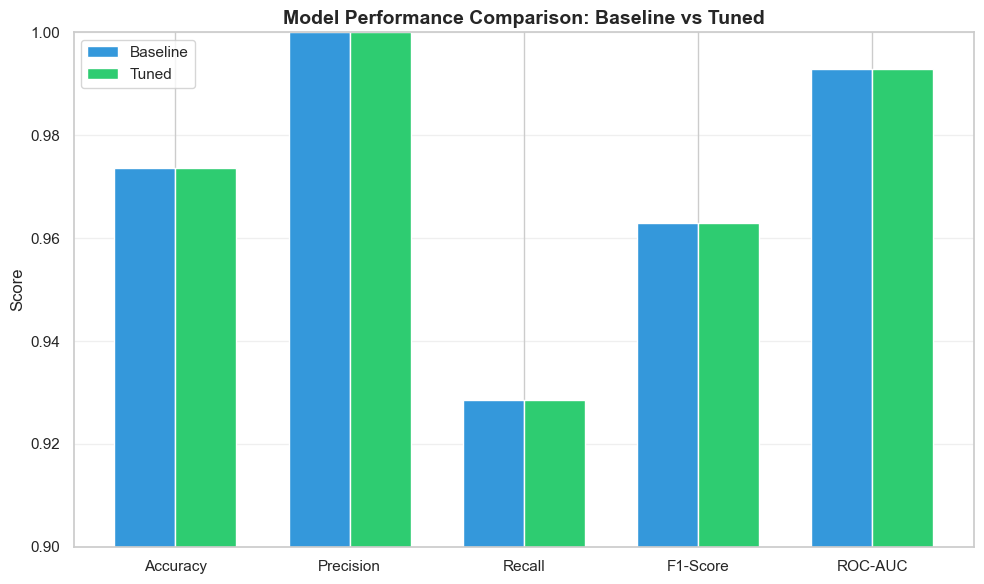

In [54]:
# Compare baseline and tuned model performance
print("="*60)
print("PERFORMANCE COMPARISON: BASELINE vs TUNED")
print("="*60)

comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'Baseline': [baseline_metrics['accuracy'], baseline_metrics['precision'],
                 baseline_metrics['recall'], baseline_metrics['f1_score'],
                 baseline_metrics['roc_auc']],
    'Tuned': [tuned_metrics['accuracy'], tuned_metrics['precision'],
              tuned_metrics['recall'], tuned_metrics['f1_score'],
              tuned_metrics['roc_auc']]
})
comparison_df['Improvement'] = comparison_df['Tuned'] - comparison_df['Baseline']
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(comparison_df['Metric']))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df['Baseline'], width, label='Baseline', color='#3498db')
bars2 = ax.bar(x + width/2, comparison_df['Tuned'], width, label='Tuned', color='#2ecc71')

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Comparison: Baseline vs Tuned', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Metric'])
ax.legend()
ax.set_ylim(0.9, 1.0)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Performance Improvement 1: Feature Selection Based on Importance

### 6.1 Feature Importance Analysis

In [55]:
# Get feature importances from the tuned model
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_tuned.feature_importances_
}).sort_values('Importance', ascending=False)

print("="*60)
print("FEATURE IMPORTANCE RANKING")
print("="*60)
print(feature_importances.to_string(index=False))

FEATURE IMPORTANCE RANKING
           Feature  Importance
             area3    0.151412
   concave_points3    0.126497
           radius3    0.093475
        perimeter3    0.083642
   concave_points1    0.081082
        perimeter1    0.077126
           radius1    0.061990
        concavity1    0.050818
             area1    0.045916
        concavity3    0.030022
             area2    0.029064
      compactness3    0.018005
          texture3    0.016174
          texture1    0.015545
       smoothness3    0.015093
           radius2    0.014503
         symmetry3    0.013301
      compactness1    0.012218
        perimeter2    0.012037
fractal_dimension2    0.006592
        concavity2    0.006083
      compactness2    0.005929
         symmetry1    0.005097
fractal_dimension3    0.004887
          texture2    0.004436
       smoothness1    0.004349
         symmetry2    0.004242
fractal_dimension1    0.003731
   concave_points2    0.003544
       smoothness2    0.003191


### 6.2 Visualize Feature Importance

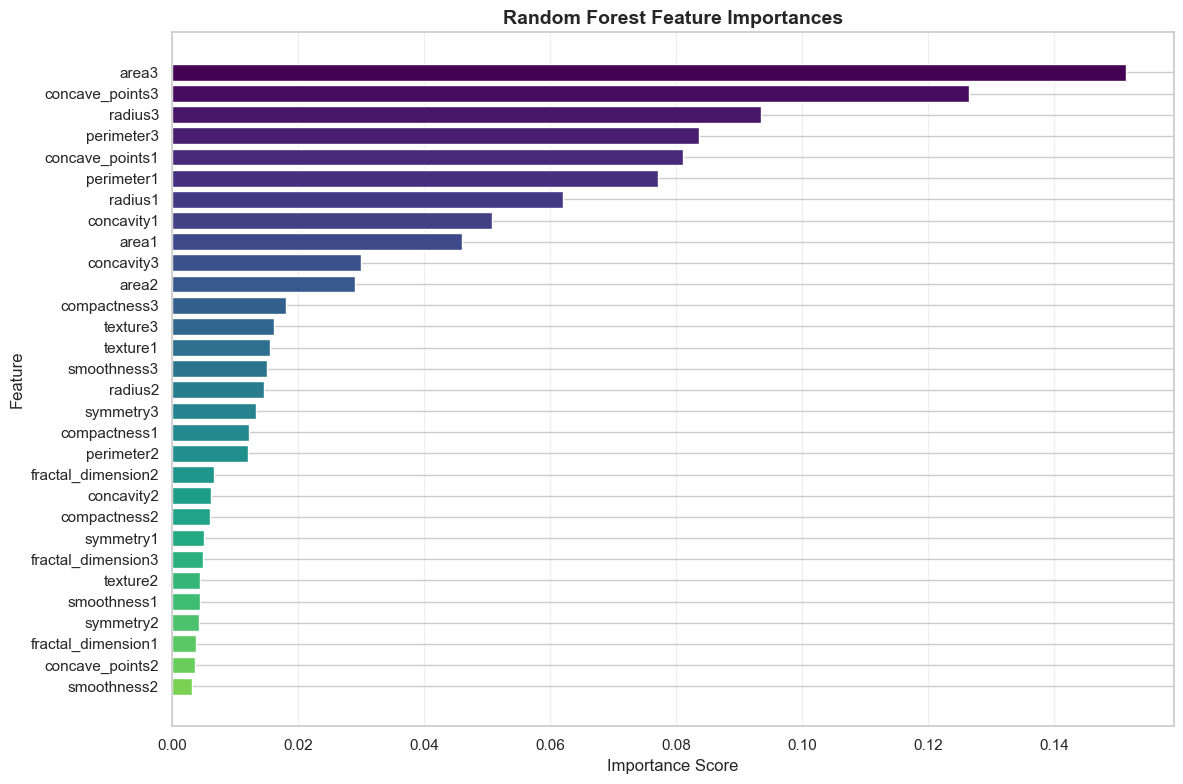

In [56]:
# Plot feature importances
plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0, 0.8, len(feature_importances)))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color=colors)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Random Forest Feature Importances', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

### 6.3 Select Top Features

In [57]:
# Select top features based on importance threshold
# Using SelectFromModel with median threshold
selector = SelectFromModel(rf_tuned, threshold='median', prefit=True)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Get selected feature names
selected_features_mask = selector.get_support()
selected_features = X.columns[selected_features_mask]

print("="*60)
print("FEATURE SELECTION RESULTS")
print("="*60)
print(f"Original number of features: {X_train.shape[1]}")
print(f"Selected number of features: {X_train_selected.shape[1]}")
print(f"\nSelected features ({len(selected_features)}):")
for i, feat in enumerate(selected_features, 1):
    importance = feature_importances[feature_importances['Feature'] == feat]['Importance'].values[0]
    print(f"  {i}. {feat}: {importance:.4f}")

FEATURE SELECTION RESULTS
Original number of features: 30
Selected number of features: 15

Selected features (15):
  1. radius1: 0.0620
  2. texture1: 0.0155
  3. perimeter1: 0.0771
  4. area1: 0.0459
  5. concavity1: 0.0508
  6. concave_points1: 0.0811
  7. area2: 0.0291
  8. radius3: 0.0935
  9. texture3: 0.0162
  10. perimeter3: 0.0836
  11. area3: 0.1514
  12. smoothness3: 0.0151
  13. compactness3: 0.0180
  14. concavity3: 0.0300
  15. concave_points3: 0.1265


### 6.4 Train Model with Selected Features

In [58]:
# Train new model with selected features
rf_feature_selected = RandomForestClassifier(
    **grid_search.best_params_,
    random_state=RANDOM_STATE
)
rf_feature_selected.fit(X_train_selected, y_train)

# Make predictions
y_pred_fs = rf_feature_selected.predict(X_test_selected)
y_pred_proba_fs = rf_feature_selected.predict_proba(X_test_selected)[:, 1]

# Evaluate model with selected features
fs_metrics = evaluate_model(
    y_test, y_pred_fs, y_pred_proba_fs,
    "Random Forest with Feature Selection"
)


RANDOM FOREST WITH FEATURE SELECTION - EVALUATION METRICS
Accuracy:  0.9737
Precision: 1.0000
Recall:    0.9286
F1-Score:  0.9630
ROC-AUC:   0.9952


## 7. Performance Improvement 2: Handling Class Imbalance with SMOTE

### 7.1 Apply SMOTE to Training Data

In [59]:
# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=RANDOM_STATE)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("="*60)
print("SMOTE OVERSAMPLING APPLIED")
print("="*60)
print(f"Original training set size: {len(y_train)}")
print(f"Resampled training set size: {len(y_train_smote)}")
print(f"\nOriginal class distribution:")
unique, counts = np.unique(y_train, return_counts=True)
for val, count in zip(unique, counts):
    print(f"  Class {val}: {count} samples")
print(f"\nResampled class distribution:")
unique, counts = np.unique(y_train_smote, return_counts=True)
for val, count in zip(unique, counts):
    print(f"  Class {val}: {count} samples")

SMOTE OVERSAMPLING APPLIED
Original training set size: 455
Resampled training set size: 570

Original class distribution:
  Class 0: 285 samples
  Class 1: 170 samples

Resampled class distribution:
  Class 0: 285 samples
  Class 1: 285 samples


### 7.2 Visualize Class Distribution Before and After SMOTE

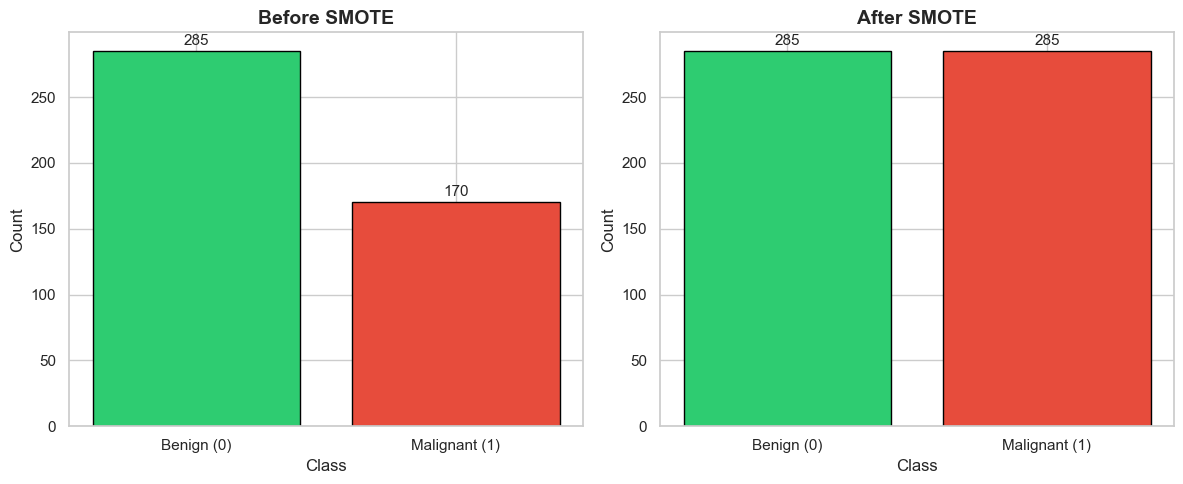

In [60]:
# Visualize class distribution before and after SMOTE
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Before SMOTE
unique, counts = np.unique(y_train, return_counts=True)
axes[0].bar(['Benign (0)', 'Malignant (1)'], counts, color=['#2ecc71', '#e74c3c'], edgecolor='black')
axes[0].set_title('Before SMOTE', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_xlabel('Class', fontsize=12)
for i, (c, v) in enumerate(zip(['Benign', 'Malignant'], counts)):
    axes[0].text(i, v + 5, str(v), ha='center', fontsize=11)

# After SMOTE
unique, counts = np.unique(y_train_smote, return_counts=True)
axes[1].bar(['Benign (0)', 'Malignant (1)'], counts, color=['#2ecc71', '#e74c3c'], edgecolor='black')
axes[1].set_title('After SMOTE', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_xlabel('Class', fontsize=12)
for i, (c, v) in enumerate(zip(['Benign', 'Malignant'], counts)):
    axes[1].text(i, v + 5, str(v), ha='center', fontsize=11)

plt.tight_layout()
plt.show()

### 7.3 Train Model with SMOTE Data

In [61]:
# Train model with SMOTE-resampled data
rf_smote = RandomForestClassifier(
    **grid_search.best_params_,
    random_state=RANDOM_STATE
)
rf_smote.fit(X_train_smote, y_train_smote)

# Make predictions
y_pred_smote = rf_smote.predict(X_test)
y_pred_proba_smote = rf_smote.predict_proba(X_test)[:, 1]

# Evaluate model with SMOTE
smote_metrics = evaluate_model(
    y_test, y_pred_smote, y_pred_proba_smote,
    "Random Forest with SMOTE"
)


RANDOM FOREST WITH SMOTE - EVALUATION METRICS
Accuracy:  0.9737
Precision: 1.0000
Recall:    0.9286
F1-Score:  0.9630
ROC-AUC:   0.9970


## 8. Combined Improvement: Feature Selection + SMOTE

### 8.1 Apply Both Techniques

In [62]:
# Apply SMOTE to feature-selected training data
X_train_fs_smote, y_train_fs_smote = smote.fit_resample(X_train_selected, y_train)

print("="*60)
print("COMBINED: FEATURE SELECTION + SMOTE")
print("="*60)
print(f"Number of features: {X_train_fs_smote.shape[1]} (after feature selection)")
print(f"Training samples: {X_train_fs_smote.shape[0]} (after SMOTE)")

# Train combined model
rf_combined = RandomForestClassifier(
    **grid_search.best_params_,
    random_state=RANDOM_STATE
)
rf_combined.fit(X_train_fs_smote, y_train_fs_smote)

# Make predictions
y_pred_combined = rf_combined.predict(X_test_selected)
y_pred_proba_combined = rf_combined.predict_proba(X_test_selected)[:, 1]

# Evaluate combined model
combined_metrics = evaluate_model(
    y_test, y_pred_combined, y_pred_proba_combined,
    "Random Forest with Feature Selection + SMOTE"
)

COMBINED: FEATURE SELECTION + SMOTE
Number of features: 15 (after feature selection)
Training samples: 570 (after SMOTE)

RANDOM FOREST WITH FEATURE SELECTION + SMOTE - EVALUATION METRICS
Accuracy:  0.9737
Precision: 1.0000
Recall:    0.9286
F1-Score:  0.9630
ROC-AUC:   0.9967


## 9. Decision Tree Visualization

### 9.1 Visualize a Single Tree from the Forest

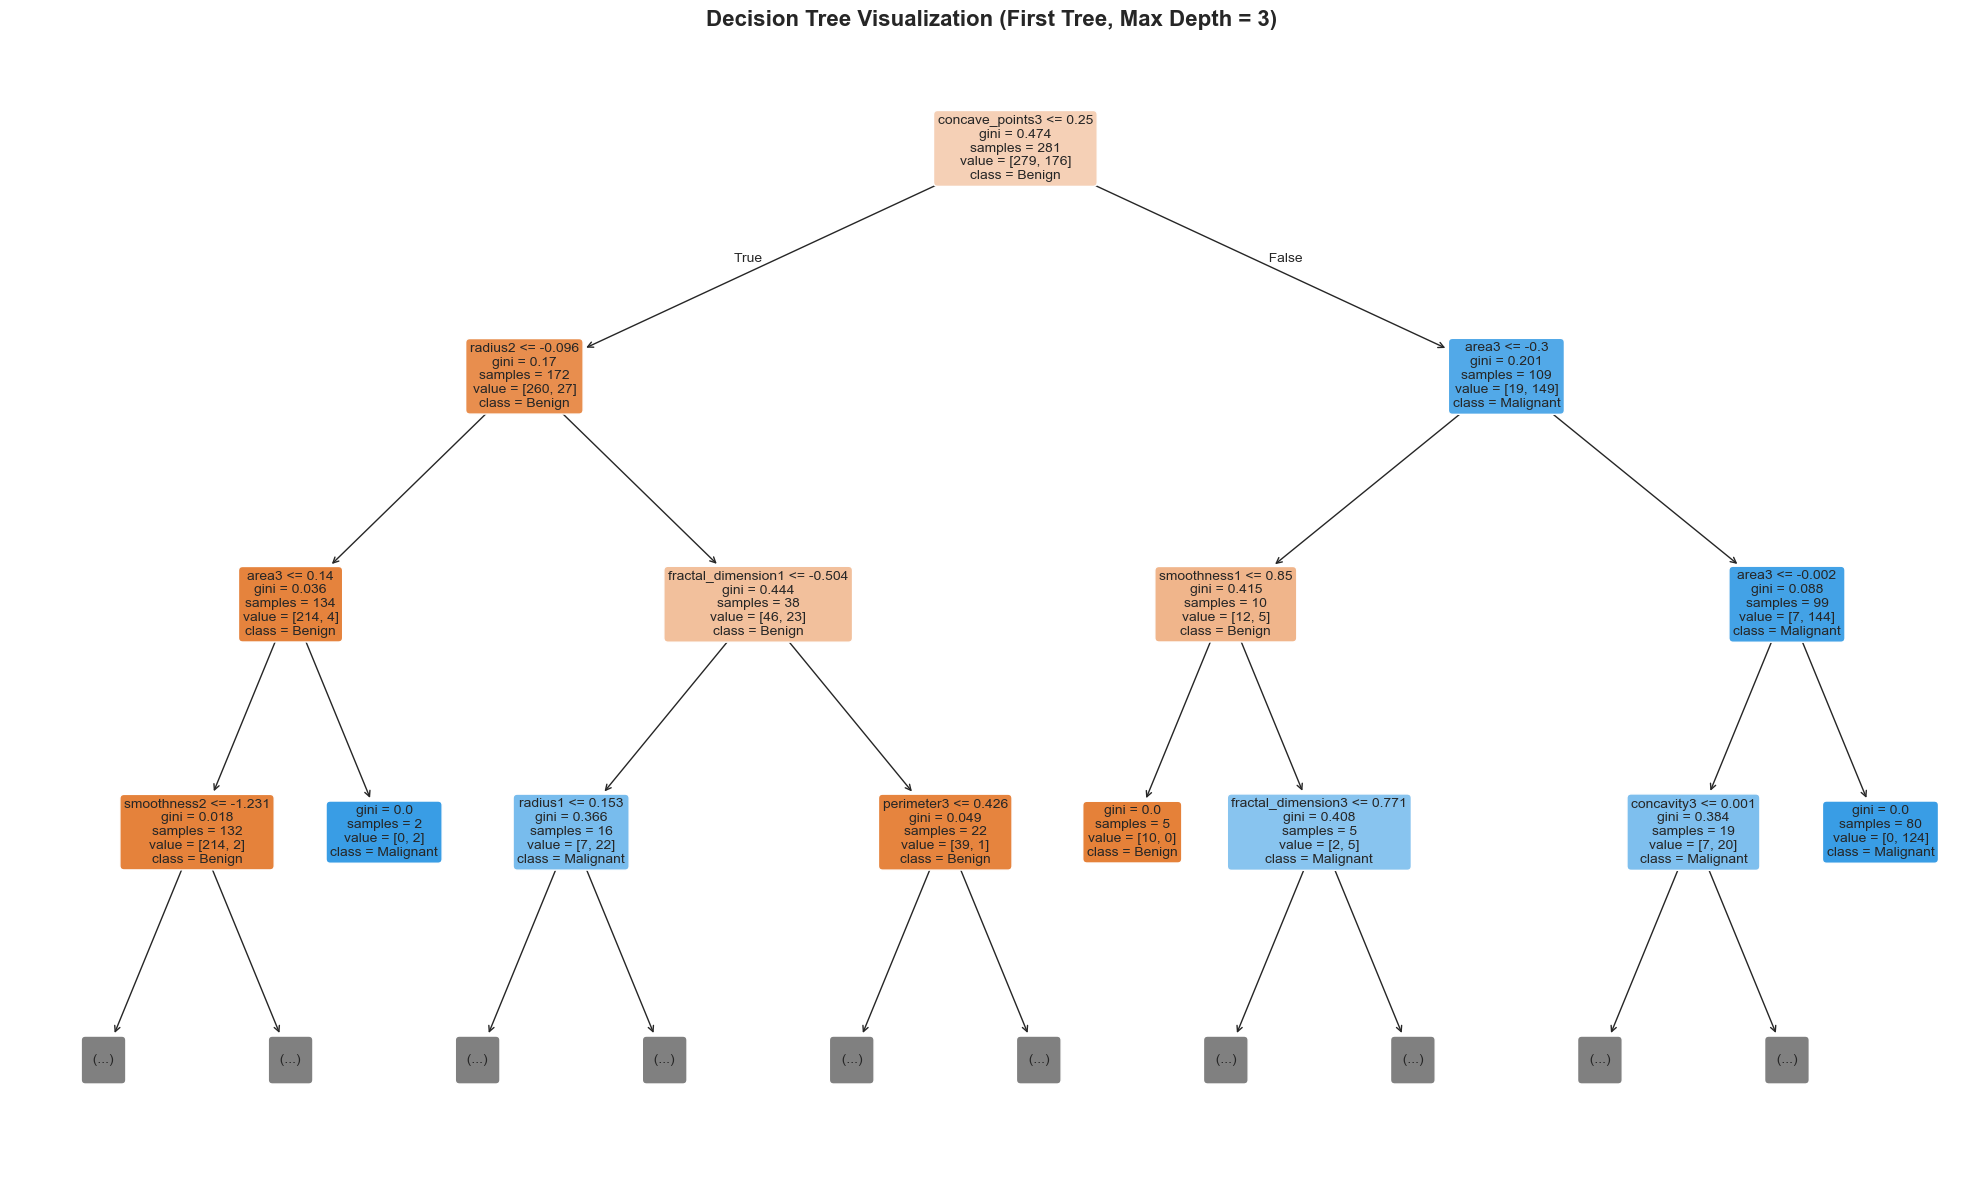

In [64]:
# Visualize one of the decision trees from the tuned Random Forest
plt.figure(figsize=(20, 12))
plot_tree(
    rf_tuned.estimators_[0],  # First tree
    feature_names=list(X.columns),
    class_names=['Benign', 'Malignant'],
    filled=True,
    rounded=True,
    max_depth=3,  # Limit depth for readability
    fontsize=10
)
plt.title('Decision Tree Visualization (First Tree, Max Depth = 3)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### 9.2 Tree with Selected Features

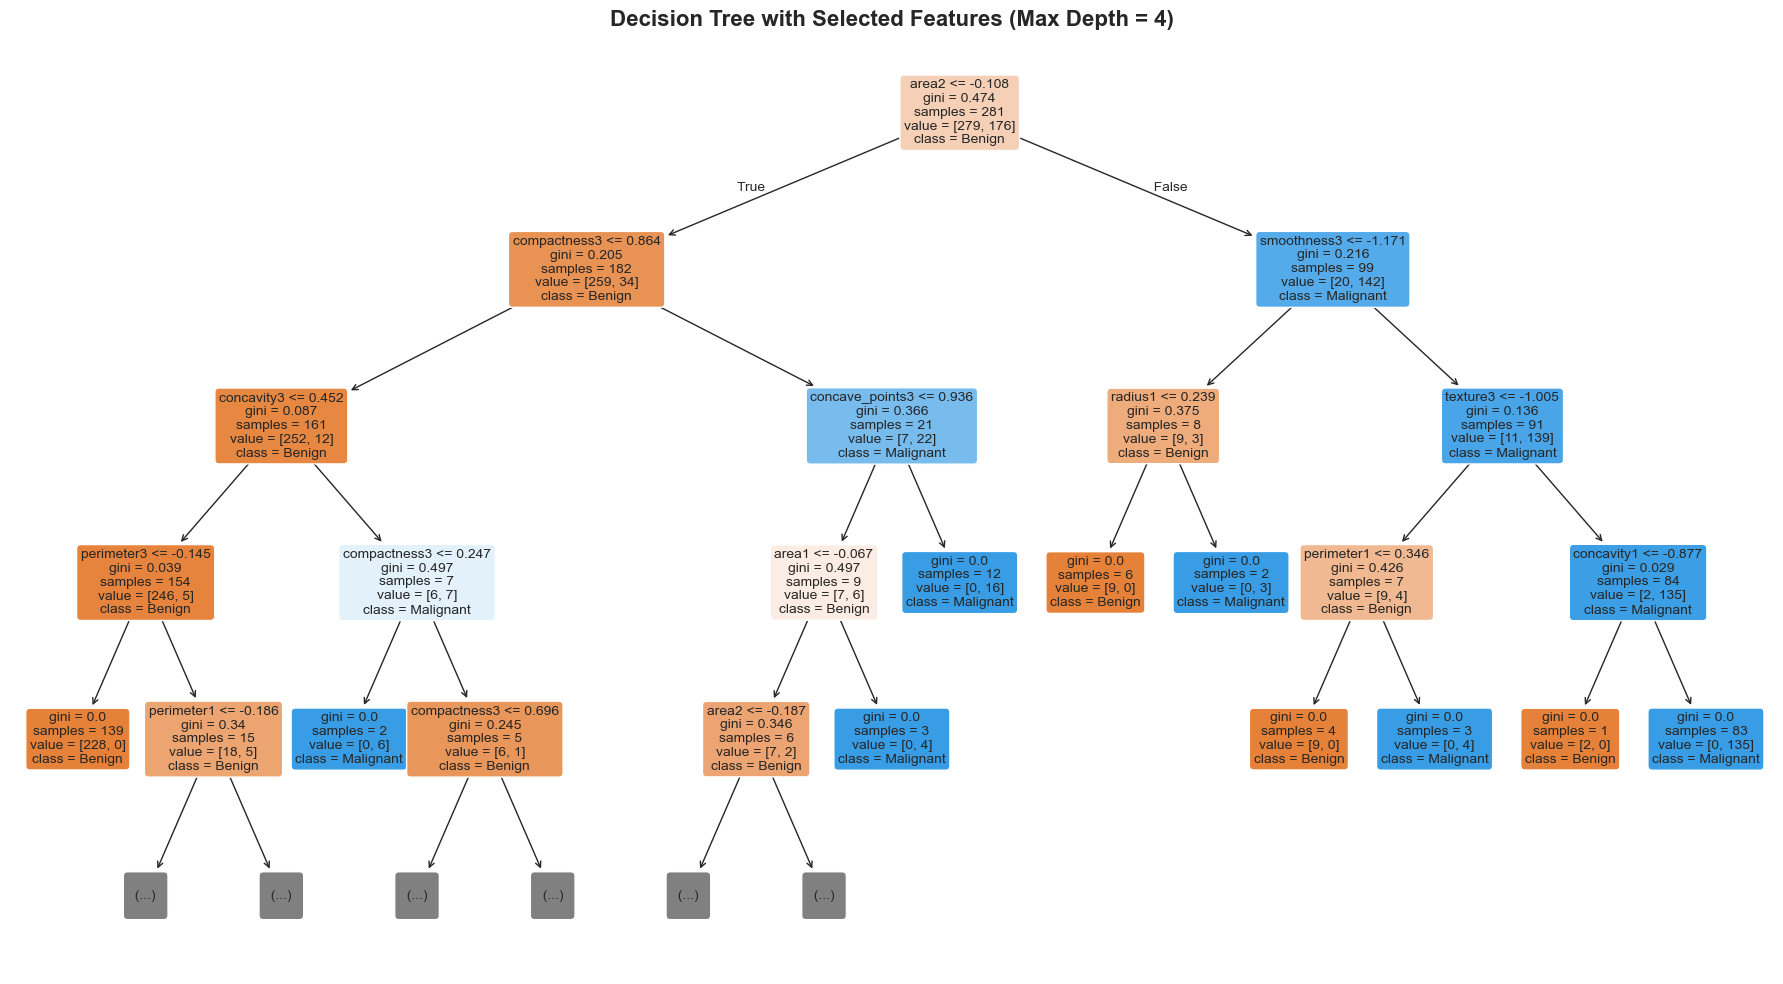

In [65]:
# Visualize a tree from the model with selected features
plt.figure(figsize=(18, 10))
plot_tree(
    rf_feature_selected.estimators_[0],
    feature_names=list(selected_features),
    class_names=['Benign', 'Malignant'],
    filled=True,
    rounded=True,
    max_depth=4,
    fontsize=10
)
plt.title('Decision Tree with Selected Features (Max Depth = 4)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 10. ROC Curves Comparison


### 10.1 Plot ROC Curves for All Models


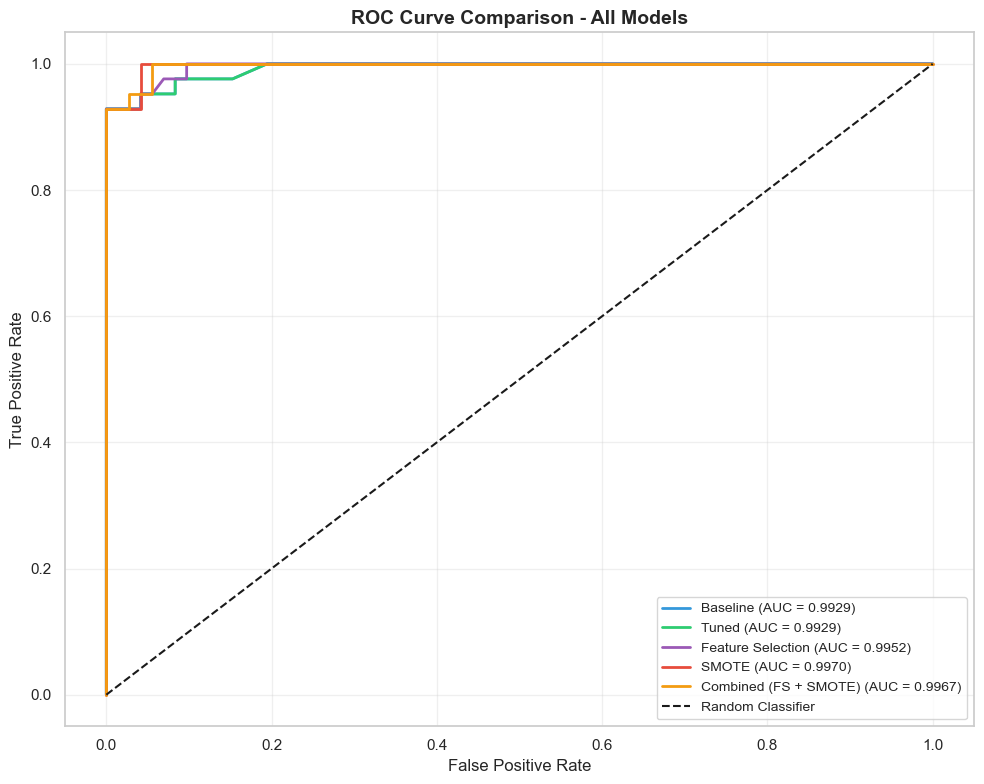

In [66]:
# Plot ROC curves for all models
plt.figure(figsize=(10, 8))

# Calculate ROC curves
models_roc = {
    'Baseline': (y_pred_proba_baseline, baseline_metrics['roc_auc']),
    'Tuned': (y_pred_proba_tuned, tuned_metrics['roc_auc']),
    'Feature Selection': (y_pred_proba_fs, fs_metrics['roc_auc']),
    'SMOTE': (y_pred_proba_smote, smote_metrics['roc_auc']),
    'Combined (FS + SMOTE)': (y_pred_proba_combined, combined_metrics['roc_auc'])
}

colors = ['#3498db', '#2ecc71', '#9b59b6', '#e74c3c', '#f39c12']

for (model_name, (proba, auc)), color in zip(models_roc.items(), colors):
    fpr, tpr, _ = roc_curve(y_test, proba)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.4f})', color=color, linewidth=2)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random Classifier')

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison - All Models', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 11. Comprehensive Model Comparison


### 11.1 Summary Table of All Models


In [68]:
# Create comprehensive comparison table
all_models = {
    'Baseline': baseline_metrics,
    'Tuned': tuned_metrics,
    'Feature Selection': fs_metrics,
    'SMOTE': smote_metrics,
    'Combined (FS+SMOTE)': combined_metrics
}

comparison_table = pd.DataFrame(all_models).T
comparison_table.columns = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
comparison_table = comparison_table.round(4)

print("="*60)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*60)
print(comparison_table.to_string())

# Highlight best values
print(f"\n{'='*60}")
print("BEST PERFORMING MODEL FOR EACH METRIC")
print("="*60)
for col in comparison_table.columns:
    best_model = comparison_table[col].idxmax()
    best_value = comparison_table[col].max()
    print(f"{col}: {best_model} ({best_value:.4f})")

COMPREHENSIVE MODEL COMPARISON
                     Accuracy  Precision  Recall  F1-Score  ROC-AUC
Baseline               0.9737        1.0  0.9286     0.963   0.9929
Tuned                  0.9737        1.0  0.9286     0.963   0.9929
Feature Selection      0.9737        1.0  0.9286     0.963   0.9952
SMOTE                  0.9737        1.0  0.9286     0.963   0.9970
Combined (FS+SMOTE)    0.9737        1.0  0.9286     0.963   0.9967

BEST PERFORMING MODEL FOR EACH METRIC
Accuracy: Baseline (0.9737)
Precision: Baseline (1.0000)
Recall: Baseline (0.9286)
F1-Score: Baseline (0.9630)
ROC-AUC: SMOTE (0.9970)


### 11.2 Heatmap Visualization of Model Comparison


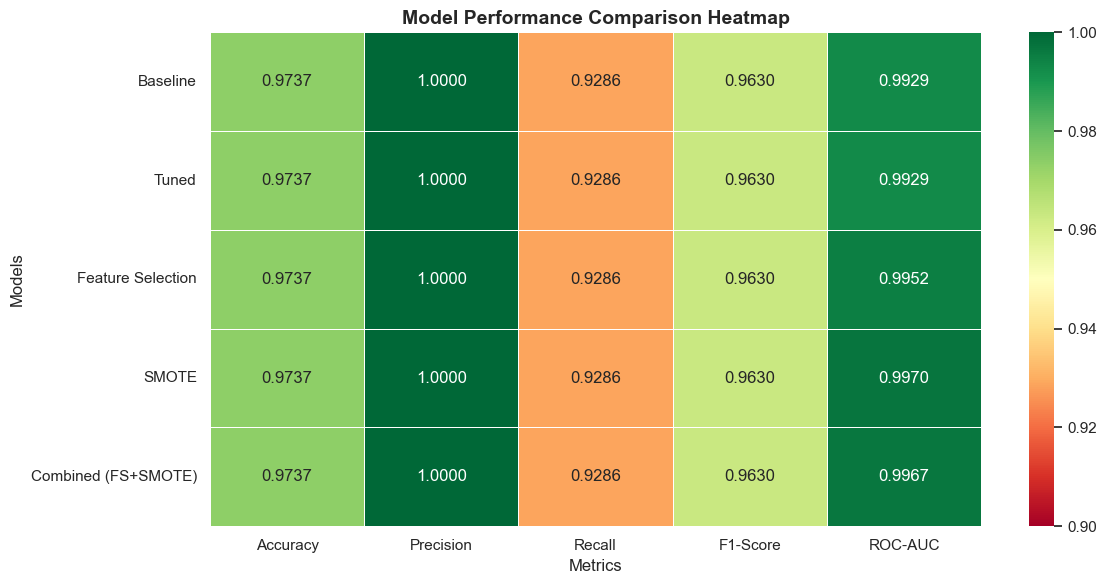

In [69]:
# Create heatmap for model comparison
plt.figure(figsize=(12, 6))
sns.heatmap(comparison_table, annot=True, fmt='.4f', cmap='RdYlGn',
            vmin=0.9, vmax=1.0, linewidths=0.5)
plt.title('Model Performance Comparison Heatmap', fontsize=14, fontweight='bold')
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Models', fontsize=12)
plt.tight_layout()
plt.show()

### 11.3 Radar Chart Comparison

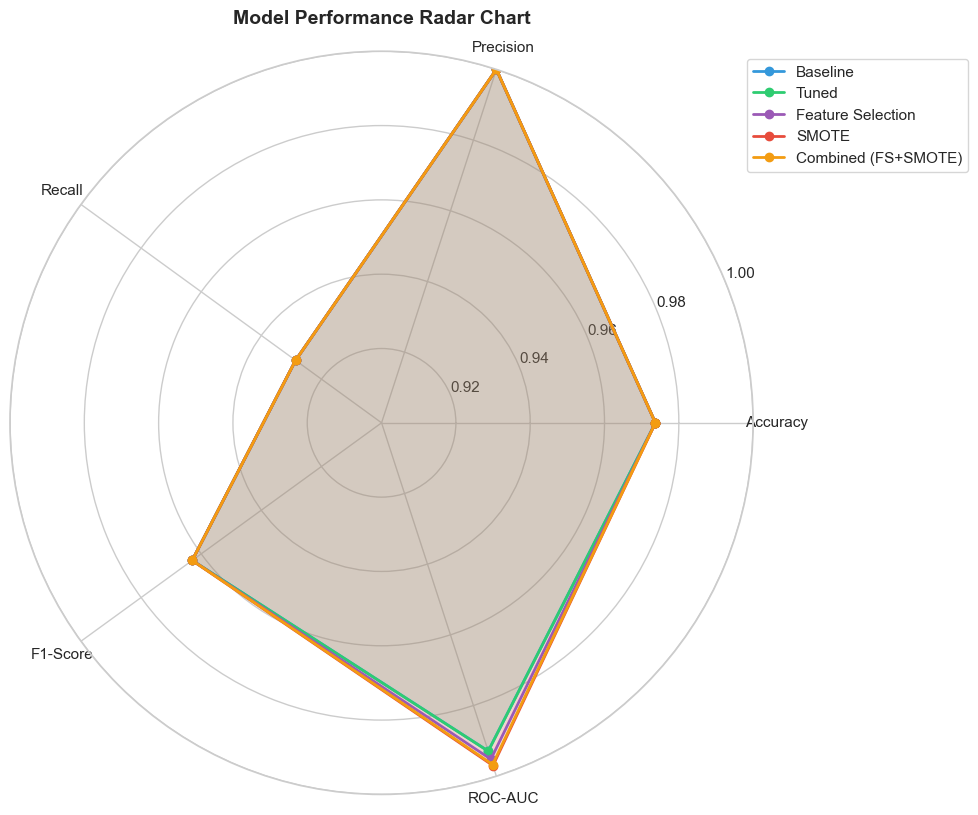

In [70]:
# Create radar chart for model comparison
from math import pi

# Prepare data for radar chart
categories = list(comparison_table.columns)
N = len(categories)

# Create angle for each metric
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

colors = ['#3498db', '#2ecc71', '#9b59b6', '#e74c3c', '#f39c12']
for (model_name, metrics), color in zip(comparison_table.iterrows(), colors):
    values = metrics.values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=model_name, color=color)
    ax.fill(angles, values, alpha=0.1, color=color)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=11)
ax.set_ylim(0.9, 1.0)
ax.set_title('Model Performance Radar Chart', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
plt.tight_layout()
plt.show()

## 12. Final Model Confusion Matrices

### 12.1 Confusion Matrices for All Models

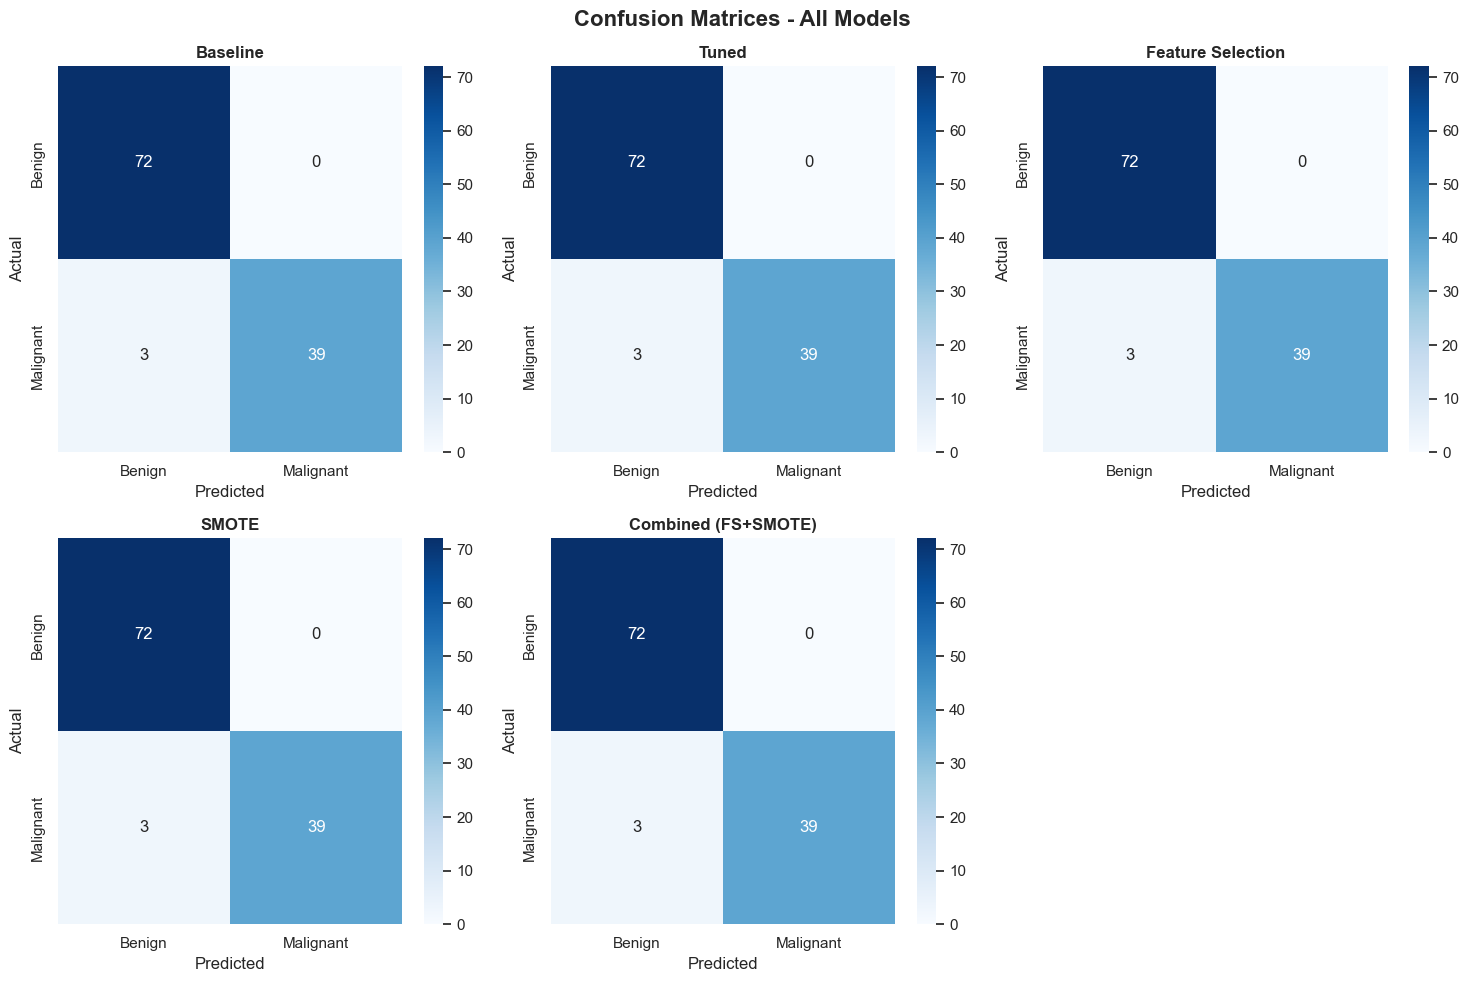

In [71]:
# Plot confusion matrices for all models
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

predictions = {
    'Baseline': y_pred_baseline,
    'Tuned': y_pred_tuned,
    'Feature Selection': y_pred_fs,
    'SMOTE': y_pred_smote,
    'Combined (FS+SMOTE)': y_pred_combined
}

for idx, (model_name, y_pred) in enumerate(predictions.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Benign', 'Malignant'],
                yticklabels=['Benign', 'Malignant'])
    axes[idx].set_title(model_name, fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

# Hide the empty subplot
axes[5].axis('off')

plt.suptitle('Confusion Matrices - All Models', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()